# Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import lag_plot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf
import pmdarima as pm

# load data

In [3]:
df = pd.read_excel("../../EsaveExportBig.xls")
df.rename(columns={df.columns[0]: "datetime"}, inplace=True)
df.rename(columns={df.columns[1]: "sensor1"}, inplace=True)
df.rename(columns={df.columns[2]: "sensor2"}, inplace=True)
datetime = df.pop("datetime")
df = df.applymap(lambda cell: float(str(cell).replace(",", ".")))

# plot sensor

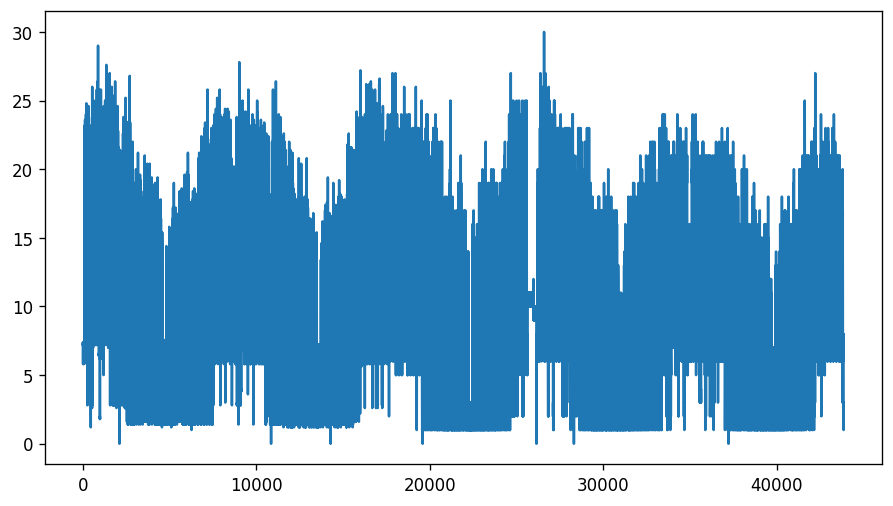

In [6]:
plt.rcParams.update({'figure.figsize':(9,5), 'figure.dpi':120})
plt.plot(df["sensor2"])
plt.show()

# multiplicative seasonal components

In [9]:
result_mul = seasonal_decompose(df["sensor2"], model='multiplicative', extrapolate_trend='freq', period=24)
result_mul.plot()
plt.show()

ValueError: Multiplicative seasonality is not appropriate for zero and negative values

# test stationary

In [10]:
# ADF Test
result = adfuller(df["sensor2"].values, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'p-value: {result[1]}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'{key}, {value}')

ADF Statistic: -21.156382217538887
p-value: 0.0
Critial Values:
1%, -3.430499321474984
Critial Values:
5%, -2.8616059968192618
Critial Values:
10%, -2.5668051279600483


# subtract best fit line (detrend)

In [ ]:
detrended = signal.detrend(df["sensor2"].values)
plt.plot(detrended)
plt.show()

# subtract trend component

In [ ]:
result_mul = seasonal_decompose(df['sensor2'], model='multiplicative', extrapolate_trend='freq', period=24*7)
detrended = df["sensor2"].values - result_mul.trend
plt.plot(detrended)
plt.show()

# deseasonilize

In [ ]:
result_mul = seasonal_decompose(df['sensor2'], model='multiplicative', extrapolate_trend='freq', period=24*7)
detrended = df["sensor2"].values - result_mul.trend
deseasonalized = df["sensor2"].values / result_mul.seasonal
plt.plot(deseasonalized)
plt.show()

# check for seasonality

In [ ]:
autocorrelation_plot(df['sensor2'].values.tolist())
plt.show()

# autocorrelation

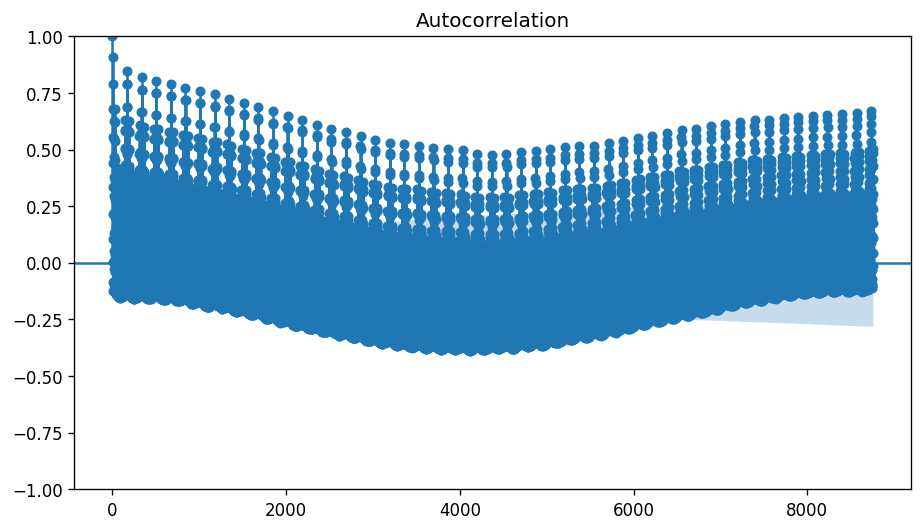

In [9]:
plot_acf(df["sensor2"].values.tolist(), lags=24*365)
plt.show()

# partial autocorrelation

c:\users\jacob\appdata\local\programs\python\python37\lib\site-packages\statsmodels\graphics\tsaplots.py:353: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  FutureWarning,


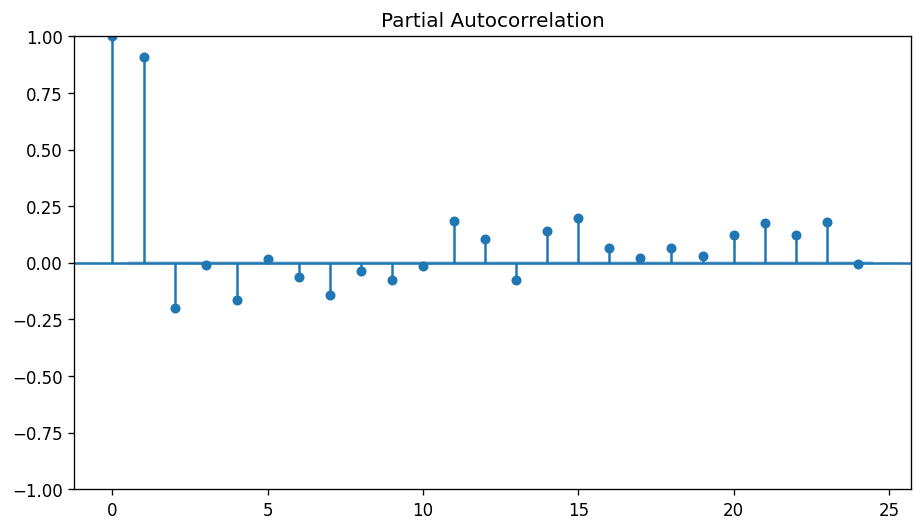

In [10]:
plot_pacf(df["sensor2"].values.tolist(), lags=24)
plt.show()

# lag plots

In [ ]:
plt.rcParams.update({'ytick.left' : False, 'axes.titlepad':10})
fig, axes = plt.subplots(1, 4, figsize=(10,3), sharex=True, sharey=True, dpi=100)
for i, ax in enumerate(axes.flatten()[:4]):
    i*= 3
    lag_plot(df["sensor2"], lag=i+1, ax=ax, c='firebrick')
    ax.set_title('Lag ' + str(i+1))

plt.show()

# create arima model

In [ ]:
model = ARIMA(df["sensor2"], order=(4,1,1))
model_fit = model.fit()
print(model_fit.summary())

# residuals

In [ ]:
residuals = pd.DataFrame(model_fit.resid)
fig, ax = plt.subplots(1,2)
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

# actual vs fitted

In [ ]:
predict = model_fit.predict(dynamic=False)
plt.plot(df["sensor2"])
plt.plot(predict)
plt.show()

# validate

In [ ]:
train = df['sensor2'][:300]
test = df['sensor2'][300:]

model = ARIMA(train, order=(4, 1, 1))  
fitted = model.fit()

sf = fitted.get_forecast(30, alpha=0.05).summary_frame()

# Forecast
fc = sf["mean"]
se = sf["mean_se"]
lower_series = sf["mean_ci_lower"]
upper_series = sf["mean_ci_upper"]

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(lower_series, index=test.index)
upper_series = pd.Series(upper_series, index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

#  create sarima model

In [ ]:
smodel = pm.auto_arima(df["sensor2"], start_p=1, start_q=1,
                         test='adf',
                         max_p=5, max_q=5, m=24,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

# forecast

In [ ]:
n_periods = 40
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(df["sensor2"].index[-1], periods = n_periods, freq='MS')

# make series for plotting purpose
fitted_series = pd.Series(fitted, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(df["sensor2"])
plt.plot(fitted_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.show()